# Leitura de arquivo .hdf, bootstrap e criação de mapa

Este programa foi criado para leitura de dados de precipitação estimada do produto 3B42 do satélite TRMM, versão 7, com criação de série e reamostragem pelo método Bootstrap, além de visualização em mapa.

Os arquivos utilizados foram adquiridos no site da NASA, STORM - NASA. O produto possui uma resolução espacial de 0,25° de latitude por 0,25° de longitude, e uma resolução temporal de 3 horas. Para o caso em questão, foram obtidos dados estimados para o período de 30/05/2017 a 04/06/2017, entre as coordenadas 36°O, 9°S e 35°O e 10°S.

## Bibliotecas necessárias

In [1]:
import pandas as pd
import os, patoolib
import numpy as np
from pyhdf.SD import SD, SDC
from random import choice

import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

## Extração de arquivos compactados em formato gzip e leitura de arquivo .hdf
As estimativas do produto do TRMM são armazenadas em arquivos no formato HDF, no entanto esses são enviados compactados em arquivos gzip, um para cada estimativa. Sendo assim, foi preciso criar uma função para extração desses arquivos (* extrair_arquivo *) e posterior leitura dos de interesse (* ler_hdf_precipitacao *).

In [2]:
def extrair_arquivos(arquivo, pasta_gzs, pasta_salvar):
    '''
    Função para extração de arquivos de um arquivo no formato gzip
    '''
    diret = pasta_gzs + arquivo
    patoolib.extract_archive(diret, outdir=pasta_salvar)

def ler_hdf_precipitacao(arquivo, pasta):
    '''
    Função para leitura de arquivo .hdf com dados de precipitação do produto 3B42 do satélite TRMM
    '''
    diret = pasta + arquivo
    hdf = SD(diret, SDC.READ)
    
    #Conjuntos de dados disponíveis
    #print(hdf.datasets())
    #Atributos 
    #print(hdf.attributes())

    #Selecionar o conjunto de dados desejado ('precipitation'): dados de precipitação
    precip = hdf.select('precipitation')
    precip = precip[:] #Array com os dados de precipitação no formato nlon x nlat
    precip = np.transpose(precip) #Matriz transposta para termos nlat x nlon
    #Substituir falhas, caso haja, por valor do tipo NaN
    np.putmask(precip,precip<0,np.nan)
    
    return precip

## Criar séries de precipitação
Também foi criada uma função para gerar as séries de precipitação estimadas, acumulá-las e obter os máximos, em cada pixel, para depois comparar com os dados de reamostragem.

In [3]:
def criar_serie(dados, lats, longs):
    '''
    Criar séries de dados estimados e acumulados, por pixel, salvando em DataFrame
    '''
    df_series = pd.DataFrame(columns=longs, index=lats)
    df_acum = pd.DataFrame(columns=longs, index=lats)
    df_max = pd.DataFrame(columns=longs, index=lats)

    for nlat, lat in enumerate(lats):
        for nlon, lon in enumerate(longs):
            serie = []
            for precip in dados_precip:
                serie.append(precip[nlat][nlon])
            df_series[lon][lat] = serie
            df_acum[lon][lat] = np.sum(serie)
            df_max[lon][lat] = max(serie)
    
    return df_series, df_acum, df_max

## Bootstrap
Criaram-se funções para aplicação do método bootstrap: realização de reamostragem (100 vezes) e cálculo do intervalo de confiança e média dos valores acumulados e máximos das novas séries criadas.

In [4]:
METRICAS = {'max': max, 'acum': sum}
def reamostragem(dados, n):
    amostras = []
    for i in range(n):
        amostras.append([choice(dados) for i in range(len(dados))])
    return amostras

def intervalo_confiança(dados):
    df = pd.Series(dados)
    return {'média': df.mean(), 'q1': df.quantile(.025), 'q3': df.quantile(.975)}

def boots(dados_estimados, metrica):
    amostras = reamostragem(dados_estimados, 100)
    res = []
    for amostra in amostras:
        res.append(METRICAS[metrica](amostra))
    return intervalo_confiança(res)

## Tabela e média
Para apresentação dos valores das séries originais e após aplicação do bootstrap, foi criada uma função para imprimir uma tabela resumo.

In [5]:
def tabela_e_media(dados, dados_acum, dados_max, lat, lon, metrica, tabela = 'SIM'):
    '''
    Impressão da tabela resumo quando parâmetro tabela estiver com o valor SIM (padrão). Caso contrártio, a 
    função retorna apenas a média do cálculo após bootstrap
    '''
    calc = boots(dados[lon][lat], metrica)
    media = '%.2f'%calc['média']
    q1 = '%.2f'%calc['q1']
    q3 = '%.2f'%calc['q3']

    if metrica == 'acum':
        met = 'Acumulado |'
        est = '%.2f'%dados_acum[lon][lat]
    else:
        met = 'Máximo    |'
        est = '%.2f'%dados_max[lon][lat]
    if tabela == 'SIM':
        print(met+media.center(9)+'|'+q1.center(14)+'|'+q3.center(14)+'||'+est.center(12))
    
    return calc['média']

## Criar mapa
Por último, fez uma função para plotar um mapa com os dados de precipitação.

In [6]:
def criar_mapa(dados, lats, longs, titulo):
    #https://github.com/SciTools/cartopy
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_extent([-37.1, -33.9, -11, -8], crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    
    m = ax.pcolormesh(longs,\
                    lats,\
                    dados,\
                    vmin=0,\
                    vmax=np.amax(dados))

    cbar = plt.colorbar(m,ax=ax)
    cbar.set_label('mm')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.35)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-34, -35, -36, -37])

    plt.title('Precipitação {}'.format(titulo))
    plt.plot()

## Rodar o programa

In [7]:
if __name__ == "__main__":
    pasta_arqsgz = os.getcwd() + './Arquivos NASA/'
    arquivos = os.listdir(pasta_arqsgz) #Lista de arquivos .gz
    gzip_files = [arquivo for arquivo in arquivos if arquivo.lower().endswith('.gz')]
    
    pasta_HDF = './Arquivos HDF/'
    if os.listdir(pasta_HDF) == []:
        #Extrair arquivos apenas se não tiverem sido descompactados
        for gzip in gzip_files:
            extrair_arquivos(gzip, pasta_arqsgz, pasta_HDF)
    
    #Pegar dados dos arquivos .hdf
    dados_precip = [] #Lista que conterá os arrays com os dados de precipitação correspondente a cada hora de medição  
    for i in range(len(os.listdir(pasta_HDF))):
        dados_precip.append(ler_hdf_precipitacao(os.listdir(pasta_HDF)[i], pasta_HDF))
    
    latitudes = np.arange(-10.25, -9, 0.25)
    longitudes = np.arange(-36.5, -35, 0.25)

    #Criar séries de dados e obter valor acumulado, por pixel
    series, acum, maxs = criar_serie(dados_precip, latitudes, longitudes)

    #Pegar médias obtidas com bootstrap e imprimir média e intervalo de confiança depois da reamostragem por Bootstrap
    df_acum = pd.DataFrame(columns=longitudes, index=latitudes)
    tabela = 'SIM'
    for lat in list(series.index):
        for lon in list(series.columns):
            if tabela == 'SIM':
                print(20*' '+'Latitude: {}; Longitude: {}'.format(lat,lon),'\n',10*' '+52*'-')
                print('Bootstrap'.center(50)+'||'+'TRMM'.center(12))
                print(10*' '+'|  Média  |  1º quartil  |  3º quartil  ||  Estimado')
            for metrica in list(METRICAS.keys()):
                if metrica == 'acum':
                    #Salvar precipitação acumulada em um DataFrame
                    df_acum[lon][lat] = tabela_e_media(series, acum, maxs, lat, lon, metrica, tabela)
                else:
                    tabela_e_media(series, acum, maxs, lat, lon, metrica, tabela)
            print('\n')
    
    for i in list(acum.columns):
        acum[i] = pd.to_numeric(acum[i], errors='coerce')
        df_acum[i] = pd.to_numeric(df_acum[i], errors='coerce')

                    Latitude: -10.25; Longitude: -36.5 
           ----------------------------------------------------
                    Bootstrap                     ||    TRMM    
          |  Média  |  1º quartil  |  3º quartil  ||  Estimado
Máximo    |   5.08  |     1.38     |     6.06     ||    6.06    
Acumulado |  14.07  |     3.06     |    29.00     ||   15.69    


                    Latitude: -10.25; Longitude: -36.25 
           ----------------------------------------------------
                    Bootstrap                     ||    TRMM    
          |  Média  |  1º quartil  |  3º quartil  ||  Estimado
Máximo    |   4.58  |     2.43     |     4.86     ||    4.86    
Acumulado |  18.77  |     5.85     |    33.38     ||   18.39    


                    Latitude: -10.25; Longitude: -36.0 
           ----------------------------------------------------
                    Bootstrap                     ||    TRMM    
          |  Média  |  1º quartil  |  3º quartil  ||  

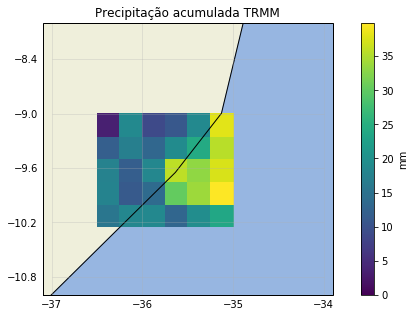

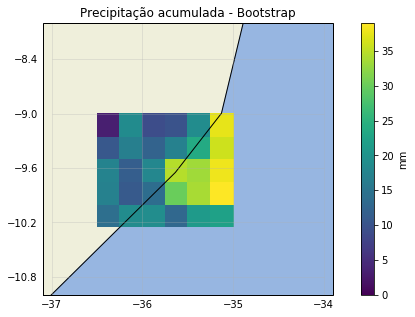

In [8]:
    #Criar mapas das precipitações acumuladas estimadas (TRMM) e de reamostragem (Bootstrap)
    latitudes = np.arange(-10.25, -8.75, 0.25)
    longitudes = np.arange(-36.5, -34.75, 0.25)
    criar_mapa(acum.values, latitudes, longitudes, 'acumulada TRMM')
    criar_mapa(df_acum.values, latitudes, longitudes, 'acumulada - Bootstrap')